### Preprocess iEEG data

In [1]:
import numpy as np
import mne
import pandas as pd
import mne_bids
import pywt
import matplotlib.pyplot as plt
from matplotlib import colormaps
import pywt
from skimage.transform import resize

from utils import resample, smooth_signal

### Specify subject's directory and meta-information 

In [2]:
bids_dir=r'C:\Users\Asus\Documents\aineuro\PtoT\ds003688\ds003688'
subjects = mne_bids.get_entity_vals(bids_dir, 'subject')

subject = '01'
acquisition = 'clinical'
task = 'film'
datatype = 'ieeg'
session = 'iemu'

### Load channels

In [3]:
channels_path = mne_bids.BIDSPath(subject=subject,
                                    session=session,
                                    suffix='channels',
                                    extension='tsv',
                                    datatype=datatype,
                                    task=task,
                                    acquisition=acquisition,
                                    root=bids_dir)
channels = pd.read_csv(str(channels_path.match()[0]), sep='\t', header=0, index_col=None)

### Load data information

In [4]:
data_path = mne_bids.BIDSPath(subject=subject,
                                    session=session,
                                    suffix='ieeg',
                                    extension='vhdr',
                                    datatype=datatype,
                                    task=task,
                                    acquisition=acquisition,
                                    root=bids_dir)
raw = mne.io.read_raw_brainvision(str(data_path.match()[0]), scale=1.0, preload=False, verbose=True)
raw.set_channel_types({ch_name: str(x).lower()
                if str(x).lower() in ['ecog', 'seeg', 'eeg'] else 'misc'
                                for ch_name, x in zip(raw.ch_names, channels['type'].values)})
raw.drop_channels([raw.ch_names[i] for i, j in enumerate(raw.get_channel_types()) if j == 'misc'])

Extracting parameters from C:/Users/Asus/Documents/aineuro/PtoT/ds003688/ds003688/sub-01/ses-iemu/ieeg/sub-01_ses-iemu_task-film_acq-clinical_run-1_ieeg.vhdr...
Setting channel info structure...


C:\Users\Asus\AppData\Local\Temp\ipykernel_32404\2865297635.py:10: RuntimeWarning: The unit for channel(s) AH+, ECG+, EMG+, MKR1+, MKR2+, ORB+, abdo+, thor+ has changed from V to NA.
  raw.set_channel_types({ch_name: str(x).lower()


Measurement date,"January 01, 1900 00:00:00 GMT"
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,103 sEEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,2048.00 Hz
Highpass,0.00 Hz
Lowpass,1024.00 Hz


### Discard bad channels

In [5]:
bad_channels = channels['name'][(channels['type'].isin(['ECOG', 'SEEG'])) & (channels['status'] == 'bad')].tolist()
raw.info['bads'].extend([ch for ch in bad_channels])
raw.drop_channels(raw.info['bads'])

Measurement date,"January 01, 1900 00:00:00 GMT"
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,101 sEEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,2048.00 Hz
Highpass,0.00 Hz
Lowpass,1024.00 Hz


### Load raw data

In [6]:
raw.load_data()

Reading 0 ... 860253  =      0.000 ...   420.045 secs...


Measurement date,"January 01, 1900 00:00:00 GMT"
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,101 sEEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,2048.00 Hz
Highpass,0.00 Hz
Lowpass,1024.00 Hz


### Apply notch filter to remove line noise

In [7]:
raw.notch_filter(freqs=np.arange(50, 251, 50))

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13517 samples (6.600 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 101 out of 101 | elapsed:    3.0s finished


Measurement date,"January 01, 1900 00:00:00 GMT"
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,101 sEEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,2048.00 Hz
Highpass,0.00 Hz
Lowpass,1024.00 Hz


### Apply common average reference to remove common noise and trends

In [8]:
raw_car, _ = mne.set_eeg_reference(raw.copy(), 'average')

sEEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('sEEG',) reference.


### Extract signal in gamma range, use Hilbert transform, but can also play around with wavelet decomposition options

In [9]:
# gamma = raw_car.copy().filter(60, 120).apply_hilbert(envelope=True).get_data().T

In [10]:
# temp = mne.time_frequency.tfr_array_morlet(np.expand_dims(self.raw_car.copy()._data, 0), # (n_epochs, n_channels, n_times)
#                                                      sfreq=self.raw.info['sfreq'],
#                                                      freqs=np.arange(60, 120),
#                                                      verbose=True,
#                                                      n_cycles=4.,
#                                                      n_jobs=1)
# gamma = np.mean(np.abs(temp), 2).squeeze().T

### Read annotation with event markers

Used Annotations descriptions: ['Stimulus/end task', 'Stimulus/music', 'Stimulus/speech']
Using matplotlib as 2D backend.


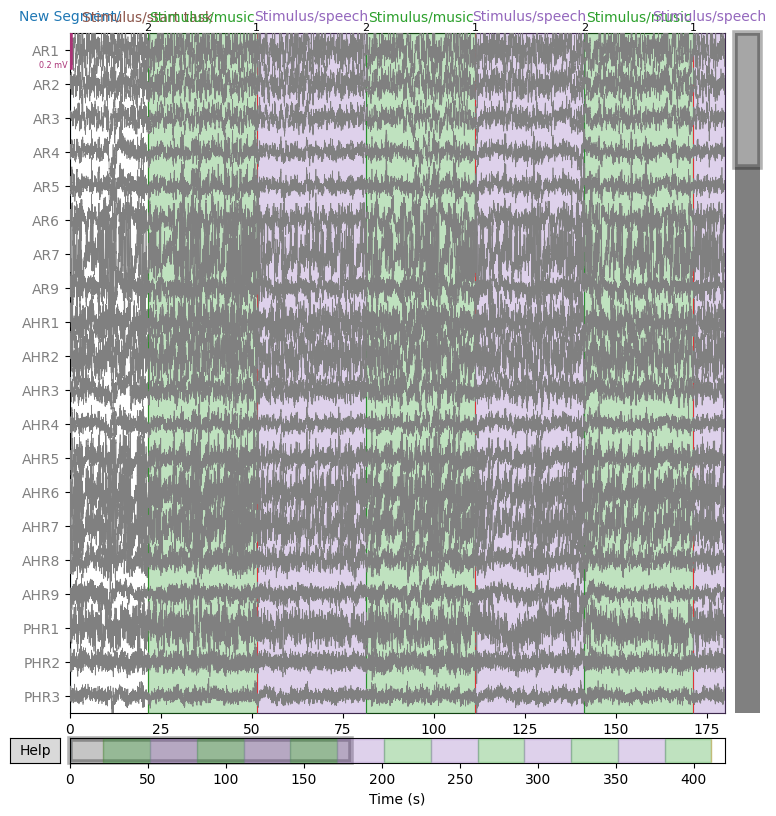

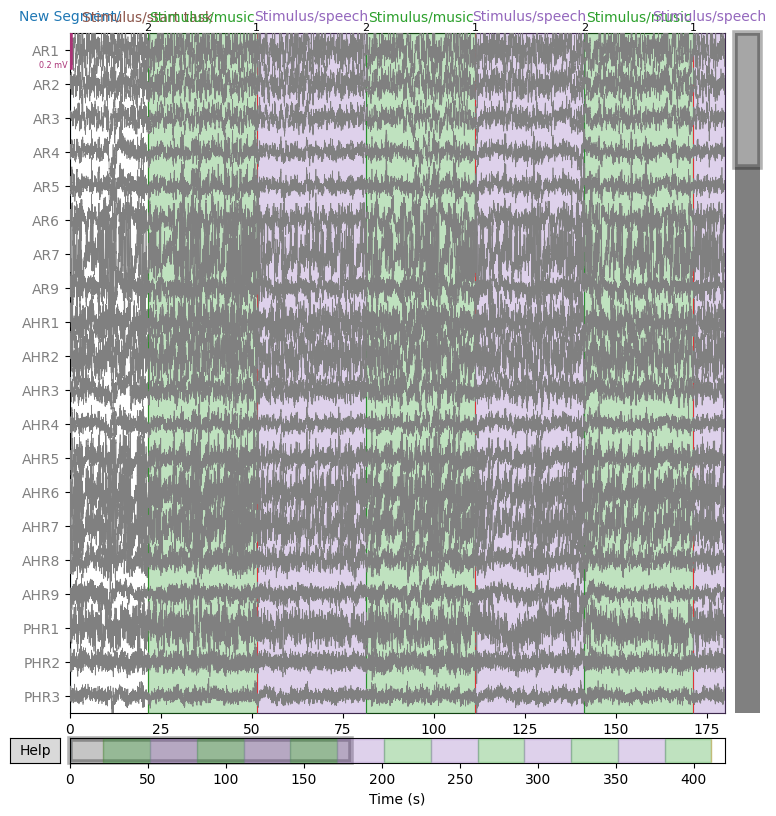

In [11]:
custom_mapping = {'Stimulus/music': 2, 'Stimulus/speech': 1,
                  'Stimulus/end task': 5}  # 'Stimulus/task end' in laan
events, event_id = mne.events_from_annotations(raw_car, event_id=custom_mapping,
                                                         use_rounding=False)

raw_car.plot(events=events, start=0, duration=180, color='gray', event_color={2: 'g', 1: 'r'}, bgcolor='w',)


### Crop signal to start and end of the task

In [12]:
# gamma_cropped = gamma[events[0, 0]:events[-1, 0]]

### Resample signal to a lower sampling rate

In [13]:
# gamma_resampled = resample(gamma_cropped, 25, int(raw.info['sfreq']))

### CWT

In [14]:
raw_car

Measurement date,"January 01, 1900 00:00:00 GMT"
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,101 sEEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,2048.00 Hz
Highpass,0.00 Hz
Lowpass,1024.00 Hz


In [ ]:
# Define the parameters
window_size_ms = 100  # window size in milliseconds
sfreq = raw_car.info['sfreq']  # sampling frequency
window_size_samples = int(window_size_ms * sfreq / 1000)  # window size in samples

# Define scales - this might need to be adjusted 
scales = 1 / (np.linspace(1, 100, num=100) * (1 / sfreq))

In [ ]:
cwt_plots = []

data, times = raw_car[:]
n_windows = data.shape[1] // window_size_samples
for i in range(n_windows):
    cwt_plots_window = []
    data_w = data[:, i*window_size_samples:(i+1)*window_size_samples] # Extract data for a 100ms window from each channel

    # Perform CWT on the extracted window for each channel
    for channel_idx in range(data.shape[0]):
        signal = data_w[channel_idx]

        # Perform CWT using the bump wavelet
        coeffs_cwt, frequencies = pywt.cwt(signal, scales, 'gaus1', 1/sfreq)  # 'gaus1' is used as a placeholder for bump
        cwt_plots_window.append(coeffs_cwt)
        
    cwt_plots.append(cwt_plots_window)

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

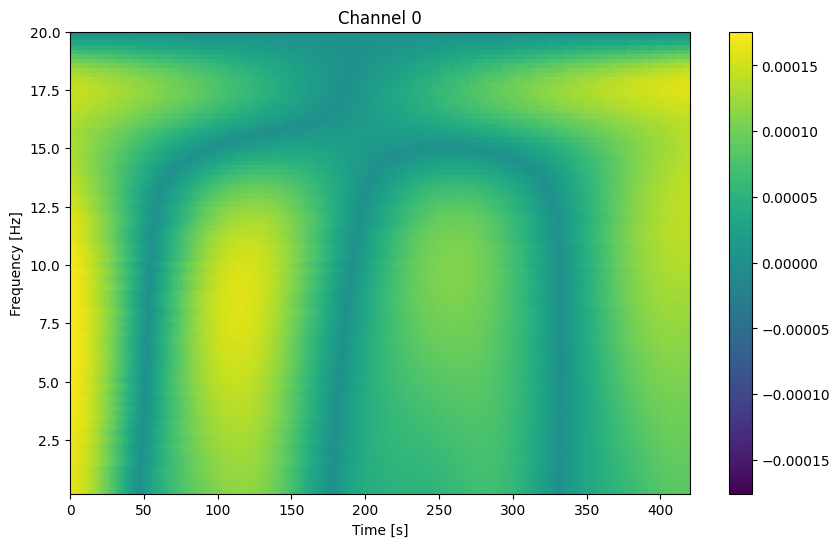

In [24]:
# Plot the CWT example result
plt.figure(figsize=(10, 6))
plt.imshow(np.abs(cwt_plots[0][0]), extent=[times[0], times[-1], frequencies[0], frequencies[-1]], aspect='auto',
            vmax=abs(cwt_plots[0][0]).max(), vmin=-abs(cwt_plots[0][0]).max())
plt.colorbar()
plt.title(f'Channel {channel_idx}')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.show()
